In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.integrate import odeint
import h5py
import math

# from mpl_toolkits.mplot3d import axes3d
# %matplotlib widget

In [2]:
Nc=4
Nf=1

In [3]:
Ns=32
Nt=8

In [4]:
nbetas = {
    '0p2000':9,
    '0p3000':8,
    '0p4000':8
}
nbins=10

In [5]:
nbetasMeas=1000

In [6]:
ibetac02 = int(np.loadtxt( "../spline_cpp/betac_ibetac_mass0p2000_"+str(Ns)+".dat" )[1])
window02 = np.arange( 780, ibetac02 )

ibetac03 = int(np.loadtxt( "../spline_cpp/betac_ibetac_mass0p3000_"+str(Ns)+".dat" )[1])
window03 = np.arange( 360, ibetac03 )

ibetac04 = int(np.loadtxt( "../spline_cpp/betac_ibetac_mass0p4000_"+str(Ns)+".dat" )[1])
window04 = np.arange( 700, ibetac04 )

In [7]:
ibetac0s = {
    "0p2000": ibetac02,
    "0p3000": ibetac03,
    "0p4000": ibetac04
}

In [8]:
windows = {
    "0p2000": window02,
    "0p3000": window03,
    "0p4000": window04
}

In [9]:
class Jackknife:
    def __init__( self, len_data, binsize ):
        self.binsize = binsize
        self.nbins = math.floor( len_data/self.binsize )
        self.N = self.binsize * self.nbins
        self.jack_avg = []
        self.est = 0
        self.var_est = 0

    def set( self, func, list_of_data ):
        for i in range( self.nbins ):
            self.jack_avg.append( func( i, self.binsize, list_of_data ) )

    def do_it( self ):
        for i in range( 0, self.nbins ):
            self.est += self.jack_avg[i]
        self.est /= self.nbins

        for i in range( 0, self.nbins ):
            self.var_est += ( self.jack_avg[i] - self.est )**2
        self.var_est /= self.nbins
        self.var_est *= self.nbins -1

    def mean( self ):
        return self.est

    def var( self ):
        return self.var_est

    def err( self ):
        return np.sqrt(self.var_est)

def simple_mean(i, binsize, np_data):
    resmpld = np.delete(np_data, np.s_[i*binsize:(i+1)*binsize], axis=0)
    return np.mean(resmpld, axis=0)

def jk_avg(i, binsize, np_data):
    return np_data[i]

def format_print(cen, err):
    for i in range(-50, 50):
        if 10**(-i+1)>=err>10**(-i):
            tmp=err*10**(i+1)
            return '{num:.{width}f}'.format(num=cen, width=i+1)+'('+str(round(tmp))+')'

def format_print_w_exact(exact, cen, err):
    for i in range(-50, 50):
        if 10**(-i+1)>=err>10**(-i):
            tmp=err*10**(i+1)
            return '{num:.{width}f}'.format(num=cen, width=i+1)+'('+str(round(tmp))+')'+': '+'{num:.{width}f}'.format(num=(exact-cen)/err, width=i+1)+' sigma'

In [10]:
class Jackknife2:
    def __init__( self, len_data, binsize ):
        self.binsize = binsize
        self.nbins = math.floor( len_data/self.binsize )
        self.N = self.binsize * self.nbins
        self.jack_avg = []
        self.est = 0
        self.cov_est = 0

    def set( self, func, list_of_data ):
        for i in range( self.nbins ):
            self.jack_avg.append( func( i, self.binsize, list_of_data ) )

    def do_it( self ):
        for i in range( 0, self.nbins ):
            self.est += self.jack_avg[i]
        self.est /= self.nbins

        for i in range( 0, self.nbins ):
            self.cov_est += np.kron( self.jack_avg[i] - self.est, self.jack_avg[i] - self.est )
        self.cov_est /= self.nbins
        self.cov_est *= self.nbins -1
        self.cov_est = self.cov_est.reshape( self.est.shape[0], self.est.shape[0] )

    def mean( self ):
        return self.est

    def cov( self ):
        return self.cov_est

    def err( self ):
        return np.sqrt(self.cov_est.diagonal())

In [11]:
gstar_HSDM = 2*(Nc**2-1)+2*Nf**2
gstar_SM = 106.75
gstar = gstar_SM + gstar_HSDM

In [12]:
MP_GeV = 1.220890 * 10**19 # GeV https://physics.nist.gov/cgi-bin/cuu/Value?plkmc2gev

In [13]:
# Get DVPrime as a func of T and MB @@ linearize around Tc

In [14]:
mass="0p2000"

In [15]:
minima = []
for ibeta in np.arange(nbetasMeas):
    tmp = np.loadtxt("../spline_cpp/fit_params_32c_m"+mass+"/minima_data_"+str(ibeta)+".dat")
    minima.append(tmp)

DeltaVhats_ = []
for ibeta in windows[mass]:
    DeltaVhat = minima[ibeta][3] - minima[ibeta][2]
    DeltaVhats_.append( DeltaVhat )
DeltaVhats_m0p2000 = np.array(DeltaVhats_)

In [16]:
# get error for each ibeta (renormalize) from jackknife
ibetacs_jk = np.loadtxt( "../spline_cpp/ibetac_jk_mass"+mass+"_"+str(Ns)+".dat" ) # renorm Tc

# err_sq = 0.0*windows2[mass]
DeltaVhats_jkdatas_m0p2000= []

for jdrop in np.arange(nbetas[mass]):

    jk_data_ = []
    for ibin in np.arange(nbins):
        print( jdrop, ibin )
        minima = []
        for ibeta in np.arange(nbetasMeas):
            tmp = np.loadtxt("../spline_cpp/fit_params_32c_m"+mass+"_jk_"+str(jdrop)+"_10_"+str(ibin)+"/minima_data_"+str(ibeta)+".dat")
            minima.append(tmp)
    
        dibeta = int(ibetacs_jk[jdrop][ibin]) - ibetac0s[mass]
    
        DeltaVhats_ = []
        for ibeta in windows[mass] + dibeta:
            DeltaVhat = minima[ibeta][3] - minima[ibeta][2]
            DeltaVhats_.append( DeltaVhat )
        DeltaVhats = np.array(DeltaVhats_)
        jk_data_.append( DeltaVhats )
    jk_data = np.array( jk_data_ )

    DeltaVhats_jkdatas_m0p2000.append( jk_data )

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
4 9
5 0
5 1
5 2
5 3
5 4
5 5
5 6
5 7
5 8
5 9
6 0
6 1
6 2
6 3
6 4
6 5
6 6
6 7
6 8
6 9
7 0
7 1
7 2
7 3
7 4
7 5
7 6
7 7
7 8
7 9
8 0
8 1
8 2
8 3
8 4
8 5
8 6
8 7
8 8
8 9


In [17]:
mass="0p3000"

In [18]:
minima = []
for ibeta in np.arange(nbetasMeas):
    tmp = np.loadtxt("../spline_cpp/fit_params_32c_m"+mass+"/minima_data_"+str(ibeta)+".dat")
    minima.append(tmp)

DeltaVhats_ = []
for ibeta in windows[mass]:
    DeltaVhat = minima[ibeta][3] - minima[ibeta][2]
    DeltaVhats_.append( DeltaVhat )
DeltaVhats_m0p3000 = np.array(DeltaVhats_)

In [19]:
# get error for each ibeta (renormalize) from jackknife
ibetacs_jk = np.loadtxt( "../spline_cpp/ibetac_jk_mass"+mass+"_"+str(Ns)+".dat" ) # renorm Tc

# err_sq = 0.0*windows2[mass]
DeltaVhats_jkdatas_m0p3000= []

for jdrop in np.arange(nbetas[mass]):

    jk_data_ = []
    for ibin in np.arange(nbins):
        print( jdrop, ibin )
        minima = []
        for ibeta in np.arange(nbetasMeas):
            tmp = np.loadtxt("../spline_cpp/fit_params_32c_m"+mass+"_jk_"+str(jdrop)+"_10_"+str(ibin)+"/minima_data_"+str(ibeta)+".dat")
            minima.append(tmp)
    
        dibeta = int(ibetacs_jk[jdrop][ibin]) - ibetac0s[mass]
    
        DeltaVhats_ = []
        for ibeta in windows[mass] + dibeta:
            DeltaVhat = minima[ibeta][3] - minima[ibeta][2]
            DeltaVhats_.append( DeltaVhat )
        DeltaVhats = np.array(DeltaVhats_)
        jk_data_.append( DeltaVhats )
    jk_data = np.array( jk_data_ )

    DeltaVhats_jkdatas_m0p3000.append( jk_data )

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
4 9
5 0
5 1
5 2
5 3
5 4
5 5
5 6
5 7
5 8
5 9
6 0
6 1
6 2
6 3
6 4
6 5
6 6
6 7
6 8
6 9
7 0
7 1
7 2
7 3
7 4
7 5
7 6
7 7
7 8
7 9


In [20]:
mass="0p4000"

In [21]:
minima = []
for ibeta in np.arange(nbetasMeas):
    tmp = np.loadtxt("../spline_cpp/fit_params_32c_m"+mass+"/minima_data_"+str(ibeta)+".dat")
    minima.append(tmp)

DeltaVhats_ = []
for ibeta in windows[mass]:
    DeltaVhat = minima[ibeta][3] - minima[ibeta][2]
    DeltaVhats_.append( DeltaVhat )
DeltaVhats_m0p4000 = np.array(DeltaVhats_)

In [22]:
# get error for each ibeta (renormalize) from jackknife
ibetacs_jk = np.loadtxt( "../spline_cpp/ibetac_jk_mass"+mass+"_"+str(Ns)+".dat" ) # renorm Tc

# err_sq = 0.0*windows2[mass]
DeltaVhats_jkdatas_m0p4000= []

for jdrop in np.arange(nbetas[mass]):

    jk_data_ = []
    for ibin in np.arange(nbins):
        print( jdrop, ibin )
        minima = []
        for ibeta in np.arange(nbetasMeas):
            tmp = np.loadtxt("../spline_cpp/fit_params_32c_m"+mass+"_jk_"+str(jdrop)+"_10_"+str(ibin)+"/minima_data_"+str(ibeta)+".dat")
            minima.append(tmp)
    
        dibeta = int(ibetacs_jk[jdrop][ibin]) - ibetac0s[mass]
    
        DeltaVhats_ = []
        for ibeta in windows[mass] + dibeta:
            DeltaVhat = minima[ibeta][3] - minima[ibeta][2]
            DeltaVhats_.append( DeltaVhat )
        DeltaVhats = np.array(DeltaVhats_)
        jk_data_.append( DeltaVhats )
    jk_data = np.array( jk_data_ )

    DeltaVhats_jkdatas_m0p4000.append( jk_data )

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
4 9
5 0
5 1
5 2
5 3
5 4
5 5
5 6
5 7
5 8
5 9
6 0
6 1
6 2
6 3
6 4
6 5
6 6
6 7
6 8
6 9
7 0
7 1
7 2
7 3
7 4
7 5
7 6
7 7
7 8
7 9


In [23]:
from f import F_ainv
from f import F_MB
from f import F_TmTc

In [24]:
f_ainv = F_ainv()
f_MB = F_MB()
f_TmTc = F_TmTc( Nt )

In [25]:
x_dx_y_dy = []

In [26]:
# 0p2

In [27]:
mq = 0.2
mass="0p2000"

In [28]:
betas_all = np.loadtxt( "../spline_cpp/betas_mass"+mass+"_32.dat" )
betac = betas_all[ibetac0s[mass]]
betas = betas_all[windows[mass]]

In [29]:
MBs = f_MB( betas, mq )
DMBs = np.array([f_MB.D( beta, mq ) for beta in betas ])

dbetas = betas - betac
TmTcs = [f_TmTc( dbeta, mq ) for dbeta in dbetas]
DTmTcs = [f_TmTc.D( dbeta, mq ) for dbeta in dbetas]

In [30]:
x_dx_y_dy.append( [ TmTcs, DTmTcs, MBs, DMBs ] )

In [31]:
# 0p3

In [32]:
mq = 0.3
mass="0p3000"

In [33]:
betas_all = np.loadtxt( "../spline_cpp/betas_mass"+mass+"_32.dat" )
betac = betas_all[ibetac0s[mass]]
betas = betas_all[windows[mass]]

In [34]:
MBs = f_MB( betas, mq )
DMBs = np.array([f_MB.D( beta, mq ) for beta in betas ])

dbetas = betas - betac
TmTcs = [f_TmTc( dbeta, mq ) for dbeta in dbetas]
DTmTcs = [f_TmTc.D( dbeta, mq ) for dbeta in dbetas]

In [35]:
x_dx_y_dy.append( [ TmTcs, DTmTcs, MBs, DMBs ] )

In [36]:
# 0p4

In [37]:
mq = 0.4
mass="0p4000"

In [38]:
betas_all = np.loadtxt( "../spline_cpp/betas_mass"+mass+"_32.dat" )
betac = betas_all[ibetac0s[mass]]
betas = betas_all[windows[mass]]

In [39]:
MBs = f_MB( betas, mq )
DMBs = np.array([f_MB.D( beta, mq ) for beta in betas ])

dbetas = betas - betac
TmTcs = [f_TmTc( dbeta, mq ) for dbeta in dbetas]
DTmTcs = [f_TmTc.D( dbeta, mq ) for dbeta in dbetas]

In [40]:
x_dx_y_dy.append( [ TmTcs, DTmTcs, MBs, DMBs ] )

In [41]:
len(x_dx_y_dy)

3

In [42]:
# def DeltaVhat_fitter(TmTc_MB, a0, b0):
#     TmTc = TmTc_MB[0]
#     MB = TmTc_MB[1]
#     return TmTc * ( a0 + b0*MB )

# def d0_DeltaVhat_fitter(TmTc_MB, a0, b0):
#     TmTc = TmTc_MB[0]
#     MB = TmTc_MB[1]
#     return ( a0 + b0*MB )

# def d1_DeltaVhat_fitter(TmTc_MB, a0, b0):
#     TmTc = TmTc_MB[0]
#     MB = TmTc_MB[1]
#     return TmTc * b0

In [46]:
def DeltaVhat_fitter(TmTc_MB, a0, b0, c0, d0):
    TmTc = TmTc_MB[0]
    MB = TmTc_MB[1]
    return TmTc * ( a0 + b0*MB ) + TmTc**2 * ( c0 + d0*MB )

# def d0_DeltaVhat_fitter(TmTc_MB, a0, b0):
#     TmTc = TmTc_MB[0]
#     MB = TmTc_MB[1]
#     return ( a0 + b0*MB )

# def d1_DeltaVhat_fitter(TmTc_MB, a0, b0):
#     TmTc = TmTc_MB[0]
#     MB = TmTc_MB[1]
#     return TmTc * b0

In [47]:
# fitparams0=[ 13.7027236, -9.83191225 ]

fitparams0=[ 13.7027236, -9.83191225, 0.0, 0.0 ]

In [70]:
# k1=40
# k2=25
# k3=30

k1=40
k2=38
k3=44

In [71]:
# TODO : JACKKNIFE IN THE GLOBAO FIT DIRECTION

In [72]:
# mean value

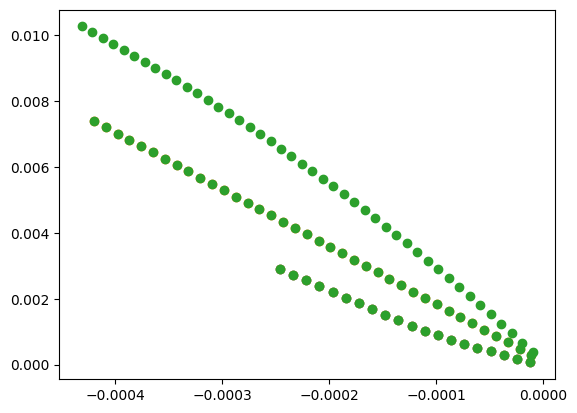

In [73]:
xs = np.array([])
dxs = np.array([])
ys = np.array([])
dys = np.array([])
zs = np.array([])

ks=[k1,k2,k3]
zpool = [ DeltaVhats_m0p2000, DeltaVhats_m0p3000, DeltaVhats_m0p4000 ]

counter=0
for row in x_dx_y_dy:
    k=ks[counter]
    xs = np.concatenate( [ xs, row[0][-k:] ] )
    dxs = np.concatenate( [ dxs, row[1][-k:] ] )
    ys = np.concatenate( [ ys, row[2][-k:] ] )
    dys = np.concatenate( [ dys, row[3][-k:] ] )
    
    zs = np.concatenate( [ zs, zpool[counter][-k:] ] )
    counter+=1
    plt.plot(xs, zs, ls='none', marker='o')

fitparams = fitparams0
for i in range(10):
    # d0s = d0_DeltaVhat_fitter( [xs,ys], fitparams[0], fitparams[1] )
    # d1s = d1_DeltaVhat_fitter( [xs,ys], fitparams[0], fitparams[1] )
    # d0s = d0_DeltaVhat_fitter( [xs,ys], fitparams[0], fitparams[1], fitparams[2], fitparams[3] )
    # d1s = d1_DeltaVhat_fitter( [xs,ys], fitparams[0], fitparams[1], fitparams[2], fitparams[3] )
    # sigma = np.sqrt( d0s**2 * dxs**2 + d1s**2 * dys**2 )
    opt = sp.optimize.curve_fit( f=DeltaVhat_fitter, xdata=[xs,ys], ydata=zs, 
                          # sigma=sigma,
                          p0=fitparams,
                          absolute_sigma=True,
                               full_output=True)
    fitparams = opt[0]

fp_mean = fitparams

In [74]:
fp_mean

array([ 2.23845161e+01, -1.34122960e+01,  3.46978544e+04, -1.26978924e+04])

In [75]:
class F_DeltaV:
    def fitter(self, TmTc_MB, a0, b0, c0, d0):
        TmTc = TmTc_MB[0]
        MB = TmTc_MB[1]
        return TmTc * ( a0 + b0*MB ) + TmTc**2 * ( c0 + d0*MB )
    
    def __init__( self, fp ):
        self.fp = fp

    def __call__( self, TmTc, MB ):
        return self.fitter( [TmTc, MB], self.fp[0], self.fp[1], self.fp[2], self.fp[3] )

In [76]:
f_DeltaV = F_DeltaV(fp_mean)

In [77]:
zs2 = f_DeltaV( xs,ys )

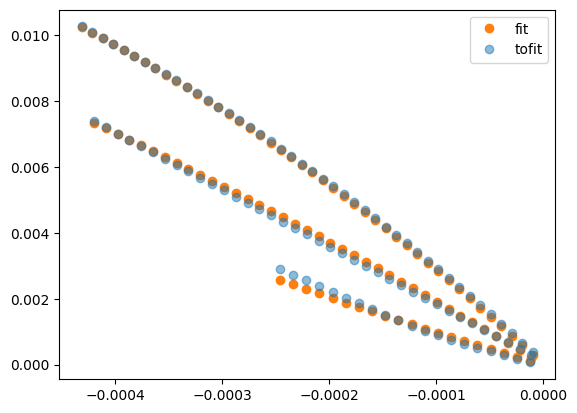

In [78]:
plt.clf()
plt.errorbar( xs, zs, 
             capsize=1, alpha=0.5, ls='none', marker='o', label='tofit' )

plt.plot( xs, zs2, ls='none', marker='o', label='fit' )


plt.legend()
# plt.plot( MBs, Tc_MB_fitter( MBs, fitparams[0], fitparams[1] ), ls='dashed' )
plt.show()

In [51]:
cov_tot = np.full( (2,2), 0. )

In [52]:
# vary m=0.2

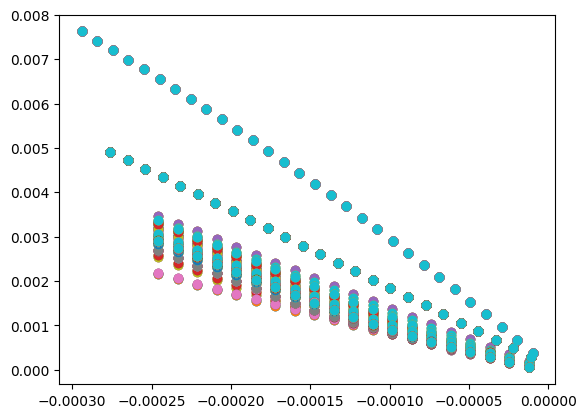

In [63]:
for jdrop in np.arange(nbetas[mass]):
    fp_jk_=[]
    for ibin in np.arange(nbins):
        xs = np.array([])
        dxs = np.array([])
        ys = np.array([])
        dys = np.array([])
        zs = np.array([])
    
        ks=[k1,k2,k3]
        zpool = [ DeltaVhats_jkdatas_m0p2000[jdrop][ibin], DeltaVhats_m0p3000, DeltaVhats_m0p4000]
        
        counter=0
        for row in x_dx_y_dy:
            k=ks[counter]
            xs = np.concatenate( [ xs, row[0][-k:] ] )
            dxs = np.concatenate( [ dxs, row[1][-k:] ] )
            ys = np.concatenate( [ ys, row[2][-k:] ] )
            dys = np.concatenate( [ dys, row[3][-k:] ] )
            
            zs = np.concatenate( [ zs, zpool[counter][-k:] ] )
            counter+=1
            plt.plot(xs, zs, ls='none', marker='o')
        
        fitparams = fitparams0
        for i in range(10):
            d0s = d0_DeltaVhat_fitter( [xs,ys], fitparams[0], fitparams[1] )
            d1s = d1_DeltaVhat_fitter( [xs,ys], fitparams[0], fitparams[1]
                                     )
            sigma = np.sqrt( d0s**2 * dxs**2 + d1s**2 * dys**2 )
            opt = sp.optimize.curve_fit( f=DeltaVhat_fitter, xdata=[xs,ys], ydata=zs, 
                                  sigma=sigma,
                                  p0=fitparams,
                                  absolute_sigma=True,
                                       full_output=True)
            fitparams = opt[0]
        
        fp_jk_.append( opt[0] )
    
    jk_data = np.array(fp_jk_)
    jk = Jackknife2( nbins, 1 )
    jk.set( jk_avg, jk_data )
    jk.do_it()
    cov_tot += jk.cov()

In [54]:
# vary m=0.3

In [55]:
for jdrop in np.arange(nbetas[mass]):
    fp_jk_=[]
    for ibin in np.arange(nbins):
        xs = np.array([])
        dxs = np.array([])
        ys = np.array([])
        dys = np.array([])
        zs = np.array([])
    
        ks=[k1,k2,k3]
        zpool = [ DeltaVhats_m0p2000, DeltaVhats_jkdatas_m0p3000[jdrop][ibin], DeltaVhats_m0p4000]
        
        counter=0
        for row in x_dx_y_dy:
            k=ks[counter]
            xs = np.concatenate( [ xs, row[0][-k:] ] )
            dxs = np.concatenate( [ dxs, row[1][-k:] ] )
            ys = np.concatenate( [ ys, row[2][-k:] ] )
            dys = np.concatenate( [ dys, row[3][-k:] ] )
            
            zs = np.concatenate( [ zs, zpool[counter][-k:] ] )
            counter+=1
        
        fitparams = fitparams0
        for i in range(10):
            d0s = d0_DeltaVhat_fitter( [xs,ys], fitparams[0], fitparams[1] )
            d1s = d1_DeltaVhat_fitter( [xs,ys], fitparams[0], fitparams[1] )
            sigma = np.sqrt( d0s**2 * dxs**2 + d1s**2 * dys**2 )
            opt = sp.optimize.curve_fit( f=DeltaVhat_fitter, xdata=[xs,ys], ydata=zs, 
                                  sigma=sigma,
                                  p0=fitparams,
                                  absolute_sigma=True,
                                       full_output=True)
            fitparams = opt[0]
        
        fp_jk_.append( opt[0] )
    
    jk_data = np.array(fp_jk_)
    jk = Jackknife2( nbins, 1 )
    jk.set( jk_avg, jk_data )
    jk.do_it()
    cov_tot += jk.cov()

In [56]:
# vary m=0.4

In [57]:
for jdrop in np.arange(nbetas[mass]):
    fp_jk_=[]
    for ibin in np.arange(nbins):
        xs = np.array([])
        dxs = np.array([])
        ys = np.array([])
        dys = np.array([])
        zs = np.array([])
    
        ks=[k1,k2,k3]
        zpool = [ DeltaVhats_m0p2000, DeltaVhats_m0p3000, DeltaVhats_jkdatas_m0p4000[jdrop][ibin], ]
        
        counter=0
        for row in x_dx_y_dy:
            k=ks[counter]
            xs = np.concatenate( [ xs, row[0][-k:] ] )
            dxs = np.concatenate( [ dxs, row[1][-k:] ] )
            ys = np.concatenate( [ ys, row[2][-k:] ] )
            dys = np.concatenate( [ dys, row[3][-k:] ] )
            
            zs = np.concatenate( [ zs, zpool[counter][-k:] ] )
            counter+=1
        
        fitparams = fitparams0
        for i in range(10):
            d0s = d0_DeltaVhat_fitter( [xs,ys], fitparams[0], fitparams[1] )
            d1s = d1_DeltaVhat_fitter( [xs,ys], fitparams[0], fitparams[1] )
            sigma = np.sqrt( d0s**2 * dxs**2 + d1s**2 * dys**2 )
            opt = sp.optimize.curve_fit( f=DeltaVhat_fitter, xdata=[xs,ys], ydata=zs, 
                                  sigma=sigma,
                                  p0=fitparams,
                                  absolute_sigma=True,
                                       full_output=True)
            fitparams = opt[0]
        
        fp_jk_.append( opt[0] )
    
    jk_data = np.array(fp_jk_)
    jk = Jackknife2( nbins, 1 )
    jk.set( jk_avg, jk_data )
    jk.do_it()
    cov_tot += jk.cov()

In [58]:
cov_tot

array([[ 647.41511618, -208.13543707],
       [-208.13543707,   69.0120997 ]])

In [59]:
fp_mean

array([ 19.50534597, -12.26295313])

In [75]:
np.loadtxt( "./cov_DeltaV_TmTc_MB.dat")

array([[27.08334532, -8.49120558],
       [-8.49120558,  2.71192913]])

In [245]:
xs = np.array([])
dxs = np.array([])
ys = np.array([])
dys = np.array([])
zs = np.array([])
dzs = np.array([])

k1=40
k2=25
k3=30

counter=0
ks=[k1,k2,k3]
for row in x_dx_y_dy_z_dz:
    k=ks[counter]
    print(k)
    counter+=1
    xs = np.concatenate( [ xs, row[0][-k:] ] )
    dxs = np.concatenate( [ dxs, row[1][-k:] ] )
    ys = np.concatenate( [ ys, row[2][-k:] ] )
    dys = np.concatenate( [ dys, row[3][-k:] ] )
    zs = np.concatenate( [ zs, row[4][-k:] ] )
    dzs = np.concatenate( [ dzs, row[5][-k:] ] )

40
25
30


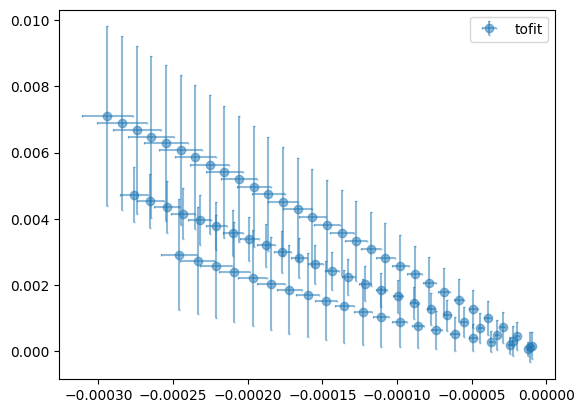

In [246]:
plt.clf()
plt.errorbar( xs, zs, 
             yerr=dzs, xerr=dxs, 
             capsize=1, alpha=0.5, ls='none', marker='o', label='tofit' )

plt.legend()
# plt.plot( MBs, Tc_MB_fitter( MBs, fitparams[0], fitparams[1] ), ls='dashed' )
plt.show()

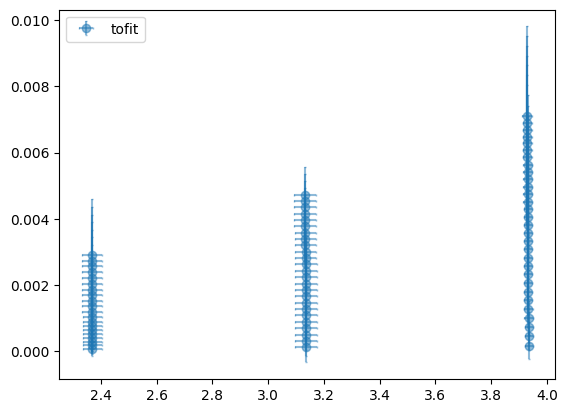

In [247]:
plt.clf()
plt.errorbar( ys, zs, 
             yerr=dzs, xerr=dys, 
             capsize=1, alpha=0.5, ls='none', marker='o', label='tofit' )

plt.legend()
# plt.plot( MBs, Tc_MB_fitter( MBs, fitparams[0], fitparams[1] ), ls='dashed' )
plt.show()

In [325]:
def DeltaVhat_fitter(TmTc_MB, a0, b0):
    TmTc = TmTc_MB[0]
    MB = TmTc_MB[1]
    return TmTc * ( a0 + b0*MB )

In [328]:
def d0_DeltaVhat_fitter(TmTc_MB, a0, b0):
    TmTc = TmTc_MB[0]
    MB = TmTc_MB[1]
    return ( a0 + b0*MB )

In [331]:
def d1_DeltaVhat_fitter(TmTc_MB, a0, b0):
    TmTc = TmTc_MB[0]
    MB = TmTc_MB[1]
    return TmTc * b0

In [332]:
# fitparams = [ 1.31956442e+00, -1.04957420e+01,  1.40702875e-01,  3.38399861e+03,
#         -2.74229509e+03]
# fitparams = [ 1.31956442e+00, -1.04957420e+01,  1.0,  3.38399861e+03, 2.0]
# fitparams = [ 0.61806225, -5.48881662, 1.23374496 ]
# fitparams = [ 0.61806225, -5.48881662, 1.23374496, 0.0, 0.0 ]

# fitparams = [  2.16296833e+00, -2.01702442e+01, -5.23189348e+03,  3.53435127e-01 ]

fitparams = [ 13.7027236, -9.83191225 ]

# fitparams = [  -2.01702442e+01, -5.23189348e+03,  3.53435127e-01 ]

In [333]:
for i in range(5):
    d0s = d0_DeltaVhat_fitter( [xs,ys], fitparams[0], fitparams[1] )
    d1s = d1_DeltaVhat_fitter( [xs,ys], fitparams[0], fitparams[1] )

    # d0s = d0_DeltaVhat_fitter( [xs,ys], fitparams[0], fitparams[1], fitparams[2] )
    # d1s = d1_DeltaVhat_fitter( [xs,ys], fitparams[0], fitparams[1], fitparams[2] )

    # d0s = d0_DeltaVhat_fitter( [xs,ys], fitparams[0], fitparams[1], fitparams[2], fitparams[3] )
    # d1s = d1_DeltaVhat_fitter( [xs,ys], fitparams[0], fitparams[1], fitparams[2], fitparams[3] )
    sigma = np.sqrt( dzs**2 + d0s**2 * dxs**2 + d1s**2 * dys**2 )
    
    opt = sp.optimize.curve_fit( f=DeltaVhat_fitter, xdata=[xs,ys], ydata=zs, 
                          sigma=sigma,
                          p0=fitparams,
                          absolute_sigma=True,
                               full_output=True)
    
    fitparams = opt[0]
    print(fitparams)

[13.68979842 -9.8279019 ]
[13.68980446 -9.82790373]
[13.68980446 -9.82790373]
[13.68980446 -9.82790373]
[13.68980446 -9.82790373]


In [334]:
np.savetxt( "./coeffs_DeltaV_TmTc_MB.dat", opt[0])
np.savetxt( "./cov_DeltaV_TmTc_MB.dat", opt[1])

In [342]:
# class F_DeltaV:
#     def fitter(self, TmTc_MB, a0, b0):
#         TmTc = TmTc_MB[0]
#         MB = TmTc_MB[1]
#         return TmTc * ( a0 + b0*MB )
    
#     def d0_fitter(self, TmTc_MB, a0, b0):
#         TmTc = TmTc_MB[0]
#         MB = TmTc_MB[1]
#         return ( a0 + b0*MB )

#     def d1_fitter(self, TmTc_MB, a0, b0):
#         TmTc = TmTc_MB[0]
#         MB = TmTc_MB[1]
#         return TmTc * b0

#     def __init__( self ):
#         self.fp = np.loadtxt( "../DeltaV/coeffs_DeltaV_TmTc_MB.dat" )
#         self.fcp = np.loadtxt( "../DeltaV/cov_DeltaV_TmTc_MB.dat" )
#         self.Dfs = [self.Df0, self.Df1 ]

#     def __call__( self, TmTc, MB ):
#         return self.fitter( [TmTc, MB], self.fp[0], self.fp[1] )

#     # def Df0( self, TmTc, MB ):
#     #     a0 = self.fp[0]
#     #     gamma = self.fp[1]
#     #     return -gamma*(MB-Mc)**(gamma-1.0)*( a0*TmTc )
    
#     def Df0( self, TmTc, MB ):
#         a0 = self.fp[0]
#         b0 = self.fp[1]
#         return TmTc
    
#     def Df1( self, TmTc, MB ):
#         a0 = self.fp[0]
#         b0 = self.fp[1]
#         return TmTc * MB

#     def D( self, TmTc, MB ):
#         df = np.array([ f(TmTc, MB) for f in self.Dfs ])
#         return np.sqrt( df@self.fcp@df )

In [343]:
# class F_DeltaV:
#     def fitter(self, TmTc_MB, a0, gamma, b0):
#         TmTc = TmTc_MB[0]
#         MB = TmTc_MB[1]
#         return (MB-Mc)**gamma*( a0*TmTc )*( 1. + b0*(MB-Mc) )

#     def d0_fitter(self, TmTc_MB, a0, gamma):
#         TmTc = TmTc_MB[0]
#         MB = TmTc_MB[1]
#         return (MB-Mc)**gamma*( a0 )

#     def d1_fitter(self, TmTc_MB, a0, gamma):
#         TmTc = TmTc_MB[0]
#         MB = TmTc_MB[1]
#         return gamma*(MB-Mc)**(gamma-1.0)*( a0*TmTc )

#     def __init__( self ):
#         self.fp = np.loadtxt( "../DeltaV/coeffs_DeltaV_TmTc_MB.dat" )
#         self.fcp = np.loadtxt( "../DeltaV/cov_DeltaV_TmTc_MB.dat" )
#         self.Dfs = [self.Df0, self.Df1 ]

#     def __call__( self, TmTc, MB ):
#         return self.fitter( [TmTc, MB], self.fp[0], self.fp[1] )

#     # def Df0( self, TmTc, MB ):
#     #     a0 = self.fp[0]
#     #     gamma = self.fp[1]
#     #     return -gamma*(MB-Mc)**(gamma-1.0)*( a0*TmTc )
    
#     def Df0( self, TmTc, MB ):
#         a0 = self.fp[0]
#         gamma = self.fp[1]
#         return (MB-Mc)**gamma*TmTc
    
#     def Df1( self, TmTc, MB ):
#         a0 = self.fp[0]
#         gamma = self.fp[1]
#         return np.log(MB-Mc)*(MB-Mc)**gamma*( a0*TmTc )

#     def D( self, TmTc, MB ):
#         df = np.array([ f(TmTc, MB) for f in self.Dfs ])
#         return np.sqrt( df@self.fcp@df )

In [344]:
# class F_DeltaV:
#     def fitter(self, TmTc_MB, Mc, a0, gamma):
#         TmTc = TmTc_MB[0]
#         MB = TmTc_MB[1]
#         return (MB-Mc)**gamma*( a0*TmTc )

#     def d0_fitter(self, TmTc_MB, Mc, a0, gamma):
#         TmTc = TmTc_MB[0]
#         MB = TmTc_MB[1]
#         return (MB-Mc)**gamma*( a0 )

#     def d1_fitter(self, TmTc_MB, Mc, a0, gamma):
#         TmTc = TmTc_MB[0]
#         MB = TmTc_MB[1]
#         return gamma*(MB-Mc)**(gamma-1.0)*( a0*TmTc )

#     def __init__( self ):
#         self.fp = np.loadtxt( "../DeltaV/coeffs_DeltaV_TmTc_MB.dat" )
#         self.fcp = np.loadtxt( "../DeltaV/cov_DeltaV_TmTc_MB.dat" )
#         self.Dfs = [self.Df0, self.Df1, self.Df2]

#     def __call__( self, TmTc, MB ):
#         return self.fitter( [TmTc, MB], self.fp[0], self.fp[1], self.fp[2] )

#     def Df0( self, TmTc, MB ):
#         Mc = self.fp[0]
#         a0 = self.fp[1]
#         gamma = self.fp[2]
#         return -gamma*(MB-Mc)**(gamma-1.0)*( a0*TmTc )
    
#     def Df1( self, TmTc, MB ):
#         Mc = self.fp[0]
#         a0 = self.fp[1]
#         gamma = self.fp[2]
#         return (MB-Mc)**gamma*TmTc
    
#     def Df2( self, TmTc, MB ):
#         Mc = self.fp[0]
#         a0 = self.fp[1]
#         gamma = self.fp[2]
#         return np.log(MB-Mc)*(MB-Mc)**gamma*( a0*TmTc )

#     def D( self, TmTc, MB ):
#         df = np.array([ f(TmTc, MB) for f in self.Dfs ])
#         return np.sqrt( df@self.fcp@df )

In [345]:
# class F_DeltaV:
#     def fitter(self, TmTc_MB, Mc, a0, b0, gamma):
#         TmTc = TmTc_MB[0]
#         MB = TmTc_MB[1]
#         return (MB-Mc)**gamma*( a0*TmTc + b0*TmTc**2 )

#     def d0_fitter(self, TmTc_MB, Mc, a0, b0, gamma):
#         TmTc = TmTc_MB[0]
#         MB = TmTc_MB[1]
#         return (MB-Mc)**gamma*( a0 + 2.0*b0*TmTc )

#     def d1_fitter(self, TmTc_MB, Mc, a0, b0, gamma):
#         TmTc = TmTc_MB[0]
#         MB = TmTc_MB[1]
#         return gamma*(MB-Mc)**(gamma-1.0)*( a0*TmTc + b0*TmTc**2 )

#     def __init__( self ):
#         self.fp = np.loadtxt( "../DeltaV/coeffs_DeltaV_TmTc_MB.dat" )
#         self.fcp = np.loadtxt( "../DeltaV/cov_DeltaV_TmTc_MB.dat" )
#         self.Dfs = [self.Df0, self.Df1, self.Df2, self.Df3]

#     def __call__( self, TmTc, MB ):
#         return self.fitter( [TmTc, MB], self.fp[0], self.fp[1], self.fp[2], self.fp[3] )

#     def Df0( self, TmTc, MB ):
#         Mc = self.fp[0]
#         a0 = self.fp[1]
#         b0 = self.fp[2]
#         gamma = self.fp[3]
#         return -gamma*(MB-Mc)**(gamma-1.0)*( a0*TmTc + b0*TmTc**2 )
    
#     def Df1( self, TmTc, MB ):
#         Mc = self.fp[0]
#         a0 = self.fp[1]
#         b0 = self.fp[2]
#         gamma = self.fp[3]
#         return (MB-Mc)**gamma*TmTc

#     def Df2( self, TmTc, MB ):
#         Mc = self.fp[0]
#         a0 = self.fp[1]
#         b0 = self.fp[2]
#         gamma = self.fp[3]
#         return (MB-Mc)**gamma*TmTc**2
    
#     def Df3( self, TmTc, MB ):
#         Mc = self.fp[0]
#         a0 = self.fp[1]
#         b0 = self.fp[2]
#         gamma = self.fp[3]
#         return np.log(MB-Mc)*(MB-Mc)**gamma*( a0*TmTc + b0*TmTc**2 )

#     def D( self, TmTc, MB ):
#         df = np.array([ f(TmTc, MB) for f in self.Dfs ])
#         return np.sqrt( df@self.fcp@df )

In [346]:
# class F_DeltaV:
#     def fitter(self, TmTc_MB, a0, b0, gamma):
#         TmTc = TmTc_MB[0]
#         MB = TmTc_MB[1]
#         return (MB-self.Mc)**gamma*( a0*TmTc + b0*TmTc**2 )

#     def d0_fitter(self, TmTc_MB, a0, b0, gamma):
#         TmTc = TmTc_MB[0]
#         MB = TmTc_MB[1]
#         return (MB-self.Mc)**gamma*( a0 + 2.0*b0*TmTc )

#     def d1_fitter(self, TmTc_MB, a0, b0, gamma):
#         TmTc = TmTc_MB[0]
#         MB = TmTc_MB[1]
#         return gamma*(MB-self.Mc)**(gamma-1.0)*( a0*TmTc + b0*TmTc**2 )

#     def __init__( self ):
#         self.Mc = np.loadtxt( "../S3/coeffs_S3hat_TmTc_MB.dat" )[0]
#         self.varMc = np.loadtxt( "../S3/cov_S3hat_TmTc_MB.dat" )[0,0]
#         self.fp = np.loadtxt( "../DeltaV/coeffs_DeltaV_TmTc_MB.dat" )
#         self.fcp = np.loadtxt( "../DeltaV/cov_DeltaV_TmTc_MB.dat" )
#         self.Dfs = [self.Df1, self.Df2, self.Df3, self.DfMc]

#     def __call__( self, TmTc, MB ):
#         return self.fitter( [TmTc, MB], self.fp[0], self.fp[1], self.fp[2] )

#     # def Df0( self, TmTc, MB ):
#     #     Mc = self.fp[0]
#     #     a0 = self.fp[1]
#     #     b0 = self.fp[2]
#     #     gamma = self.fp[3]
#     #     return -gamma*(MB-self.Mc)**(gamma-1.0)*( a0*TmTc + b0*TmTc**2 )
    
#     def Df1( self, TmTc, MB ):
#         a0 = self.fp[0]
#         b0 = self.fp[1]
#         gamma = self.fp[2]
#         return (MB-self.Mc)**gamma*TmTc

#     def Df2( self, TmTc, MB ):
#         a0 = self.fp[0]
#         b0 = self.fp[1]
#         gamma = self.fp[2]
#         return (MB-self.Mc)**gamma*TmTc**2
    
#     def Df3( self, TmTc, MB ):
#         a0 = self.fp[0]
#         b0 = self.fp[1]
#         gamma = self.fp[2]
#         return np.log(MB-self.Mc)*(MB-self.Mc)**gamma*( a0*TmTc + b0*TmTc**2 )

#     def DfMc( self, TmTc, MB ):
#         a0 = self.fp[0]
#         b0 = self.fp[1]
#         gamma = self.fp[2]
#         return -gamma*(MB-self.Mc)**(gamma-1.0)*( a0*TmTc + b0*TmTc**2 )

#     def D( self, TmTc, MB ):
#         df = np.array([ f(TmTc, MB) for f in self.Dfs ])
#         m3 = self.fcp
#         var = self.varMc
#         m4 = np.full( np.array(m3.shape)+1, 0 )
#         m4[:3,:3] = m3
#         m4[3,3] = var
#         return np.sqrt( df@m4@df )

In [347]:
f_DeltaV = F_DeltaV()

In [349]:
f = F_DeltaV()

eps=1.0e-6

i=0

fpp = np.copy(f.fp)
fpm = np.copy(f.fp)

fpp[i]+=eps
fpm[i]-=eps

TmTc=-0.0006
MB=2.4

f( TmTc, MB )

# fp = f.fitter( [TmTc, MB], fpp[0], fpp[1], fpp[2], fpp[3] )
# fm = f.fitter( [TmTc, MB], fpm[0], fpm[1], fpm[2], fpm[3] )

# fp = f.fitter( [TmTc, MB], fpp[0], fpp[1], fpp[2] )
# fm = f.fitter( [TmTc, MB], fpm[0], fpm[1], fpm[2] )

fp = f.fitter( [TmTc, MB], fpp[0], fpp[1] )
fm = f.fitter( [TmTc, MB], fpm[0], fpm[1] )
(fp-fm)/(2.0*eps), f.Dfs[i](TmTc, MB)

(-0.0005999999997709227, -0.0006)

In [350]:
zs2 = f_DeltaV( xs,ys )

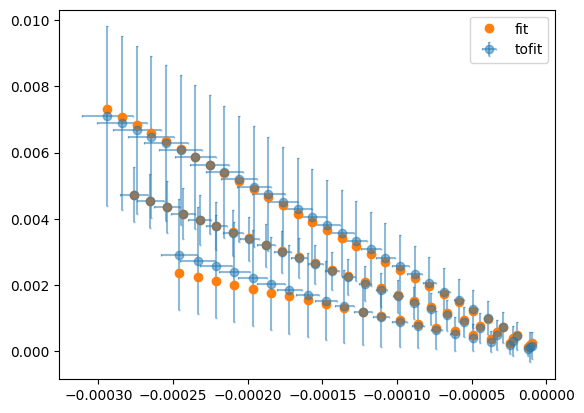

In [351]:
plt.clf()
plt.errorbar( xs, zs, 
             yerr=dzs, xerr=dxs, 
             capsize=1, alpha=0.5, ls='none', marker='o', label='tofit' )

plt.plot( xs, zs2, ls='none', marker='o', label='fit' )


plt.legend()
# plt.plot( MBs, Tc_MB_fitter( MBs, fitparams[0], fitparams[1] ), ls='dashed' )
plt.show()

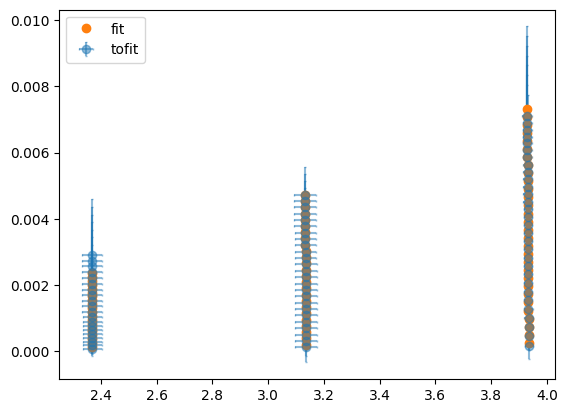

In [352]:
plt.clf()
plt.errorbar( ys, zs, 
             yerr=dzs, xerr=dys, 
             capsize=1, alpha=0.5, ls='none', marker='o', label='tofit' )

plt.plot( ys, zs2, ls='none', marker='o', label='fit' )


plt.legend()
# plt.plot( MBs, Tc_MB_fitter( MBs, fitparams[0], fitparams[1] ), ls='dashed' )
plt.show()

In [353]:
opt[0]

array([13.68980446, -9.82790373])

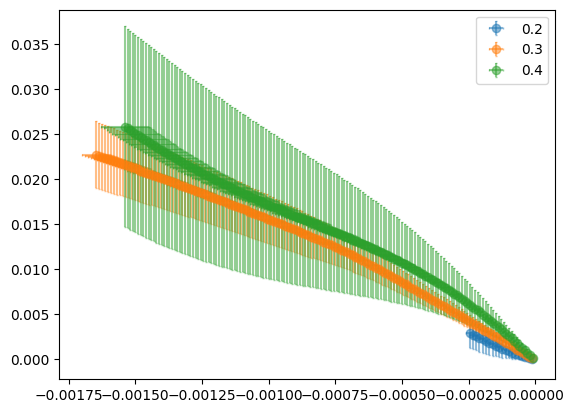

In [354]:
plt.clf()
plt.errorbar( x_dx_y_dy_z_dz[0][0], x_dx_y_dy_z_dz[0][4], 
             yerr=x_dx_y_dy_z_dz[0][5], xerr=x_dx_y_dy_z_dz[0][1], 
             capsize=1, alpha=0.5, ls='none', marker='o', label='0.2' )

plt.errorbar( x_dx_y_dy_z_dz[1][0], x_dx_y_dy_z_dz[1][4], 
             yerr=x_dx_y_dy_z_dz[1][5], xerr=x_dx_y_dy_z_dz[1][1], 
             capsize=1, alpha=0.5, ls='none', marker='o', label='0.3' )

plt.errorbar( x_dx_y_dy_z_dz[2][0], x_dx_y_dy_z_dz[2][4], 
             yerr=x_dx_y_dy_z_dz[2][5], xerr=x_dx_y_dy_z_dz[2][1], 
             capsize=1, alpha=0.5, ls='none', marker='o', label='0.4' )

plt.legend()
# plt.plot( MBs, Tc_MB_fitter( MBs, fitparams[0], fitparams[1] ), ls='dashed' )
plt.show()

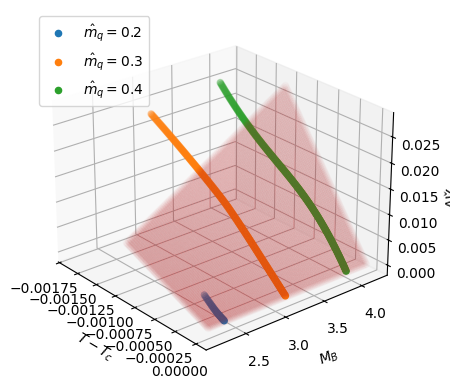

In [355]:
plt.clf()
ax = plt.axes(projection='3d')

ax.scatter( x_dx_y_dy_z_dz[0][0], x_dx_y_dy_z_dz[0][2], x_dx_y_dy_z_dz[0][4], label='$\\hat{m}_q=0.2$' )
ax.scatter( x_dx_y_dy_z_dz[1][0], x_dx_y_dy_z_dz[1][2], x_dx_y_dy_z_dz[1][4], label='$\\hat{m}_q=0.3$' )
ax.scatter( x_dx_y_dy_z_dz[2][0], x_dx_y_dy_z_dz[2][2], x_dx_y_dy_z_dz[2][4], label='$\\hat{m}_q=0.4$' )

xx1 = np.repeat(np.linspace(-0.001, 0.0, 100), 100).reshape(100,100)
xx2 = np.repeat(np.linspace(2.163, 4.2, 100), 100).reshape(100,100).T
yy_fit2 = zs2 = f_DeltaV( xx1, xx2 )
ax.scatter( xx1, xx2, yy_fit2, alpha=0.02 )

ax.view_init(elev=25, azim=-40, roll=0)

ax.set_xlabel("$T-T_c$")
ax.set_ylabel("$M_B$")
ax.set_zlabel("$\\Delta {V}\\check$")

plt.legend()

# plt.savefig("DeltaV.pdf", bbox_inches='tight')
plt.show()

In [356]:
Mc = np.loadtxt( "../S3/coeffs_S3hat_TmTc_MB.dat" )[0]
varMc = np.loadtxt( "../S3/cov_S3hat_TmTc_MB.dat" )[0,0]

In [182]:
Mc, np.sqrt(varMc)

(2.2940954028706697, 0.05061947697323283)

In [183]:
Mc2 = np.loadtxt( "../DeltaV/coeffs_DeltaV_TmTc_MB.dat" )[0]
varMc2 = np.loadtxt( "../DeltaV/cov_DeltaV_TmTc_MB.dat" )[0,0]

In [184]:
Mc2, np.sqrt(varMc2)

(1.4406460637174296, 1.27443743212529)